<a href="https://colab.research.google.com/github/dxganta/eeg-deep-learning/blob/main/mnist_digit_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mnist Digit Detection using a Convolutional Neural Network



## Summary

Using a convolutional neural network to predict whether a subject was thinking about a digit or not using the subject's EEG data recorded using a Muse headset.

The dataset used can be found here, [MindBigData recorded by David Vivancos](http://mindbigdata.com/opendb/index.html). Though, MindBigData contains eeg recorded from a variety of datasets, the muse database was used here.



## Results

The model was able to predict whether a particular eeg recording was a digit or not with around **84-86%** validation accuracy. The model used was **resnet34** and though the whole dataset contains 163,932 data points, only 3000 data points were used for the training. 1500 of them being digits and 1500 being non-digits.


TODO:
1. Download mnist muse dataset from [MindBigData](http://mindbigdata.com/opendb/index.html)
2. Convert it to images to feed to conv neural network
3. Train the network using fastai
4. Get accuracy

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import time
import shutil
from fastai.vision.all import *
from scipy.fft import fft, ifft
from scipy import interpolate

### Util methods

In [1]:
srate = 220

def time_frequency(data, cmwX, nKern):
    ''''
    Function to calculate time-frequency representation of multichannel data.

    Parameters:
    data : ndarray
        The EEG data, array of shape (channels, time).
    cmwX : ndarray
        The Fourier coefficients of the complex Morlet wavelets, array of shape (frequencies, nConv).
    nKern : int
        The length of the wavelet kernel.
    channel_labels : list, optional
        The labels of the EEG channels. Must be the same length as the number of channels in the data.
        If not provided, no channel labels will be used.

    Returns:
    tf : ndarray
        The time-frequency representation of the data, array of shape (frequencies, time).
        This is the average power across all channels.
    '''

    # set up convolution parameters
    nData   = data.shape[1]
    nConv   = nData + nKern - 1
    halfwav = (nKern-1)//2

    # initialize time-frequency output matrix
    tf = np.zeros((data.shape[0], cmwX.shape[0], data.shape[1])) # channels X frequency X times

    # loop over channels
    for chani in range(data.shape[0]):

        # compute Fourier coefficients of EEG data
        eegX = fft(data[chani, :] , nConv)

        # perform convolution and extract power (vectorized across frequencies)
        as_ = ifft(cmwX * eegX[None, :], axis=1)
        as_ = as_[:, halfwav: -halfwav]
        tf[chani, :, :] = np.abs(as_) ** 2

    return tf


def get_cmwX(nData, freqrange=[1,40], numfrex=42):
    '''
    Function to calculate the Fourier coefficients of complex Morlet wavelets.

    Parameters:
    nData : int
        The number of data points.
    freqrange : list, optional
        The range of frequencies to consider. Defaults to [1,40].
    numfrex : int, optional
        The number of frequencies between the lowest and highest frequency. Defaults to 42.

    Returns:
    cmwX : ndarray
        The Fourier coefficients of the complex Morlet wavelets, array of shape (frequencies, nConv).
    nKern : int
        The length of the wavelet kernel.
    frex : ndarray
        The array of frequencies.
    '''
    pi = np.pi
    wavtime = np.arange(-2,2-1/srate,1/srate)
    nKern = len(wavtime)
    nConv = nData + nKern - 1
    frex = np.linspace(freqrange[0],freqrange[1],numfrex)
   # create complex morlet wavelets array
    cmwX = np.zeros((numfrex, nConv), dtype=complex)

    # number of cycles
    numcyc = np.linspace(3,15,numfrex);
    for fi in range(numfrex):
        # create time-domain wavelet
        s = numcyc[fi] / (2*pi*frex[fi])
        twoSsquared = (2*s) ** 2
        cmw = np.exp(2*1j*pi*frex[fi]*wavtime) * np.exp( (-wavtime**2) / twoSsquared )


        # compute fourier coefficients of wavelet and normalize
        cmwX[fi, :] = fft(cmw, nConv)
        cmwX[fi, :] = cmwX[fi, :] / max(cmwX[fi, :])

    return cmwX, nKern, frex

# Function to resample an array to the target length
def resample_array(array, target_length):
    # Create an array of indices for the input array
    input_indices = np.linspace(0, len(array)-1, len(array))

    # Create an array of indices for the resampled array
    resampled_indices = np.linspace(0, len(array)-1, target_length)

    # Create a linear interpolation function based on the input array
    interpolator = interpolate.interp1d(input_indices, array)

    # Use the interpolator to create the resampled array
    resampled_array = interpolator(resampled_indices)

    return resampled_array.tolist()

### Data Cleaning & Pre-Processing

Replace mnist_path with the location of the dataset in your system.

As you can see, I am taking 1500 rows from the start of the data (which are digits) and 1500 rows from the end of the data (which are non-digits) and concaneting the 2 dfs to create a single df containing both digits and non-digits eeg recordings.

In [3]:
mnist_path = 'drive/MyDrive/EEG-Data/MU.txt'
# Load the file into a pandas DataFrame
mnist_df = pd.read_csv(mnist_path, sep='\t', header=None, nrows=1500)
mnist_df.columns = ['id', 'event_id', 'device', 'channel', 'code', 'size', 'data']

resting_df = pd.read_csv(mnist_path, sep='\t', names=mnist_df.columns, header=None, skiprows=130000, nrows=1500)
df = pd.concat([mnist_df, resting_df])
df["data"] = df["data"].apply(lambda x: [float(i) for i in x.split(",")])


# Define the column names
pnts = df.shape[0]

# Display the first few rows of the DataFrame
df.head()

,id,event_id,device,channel,code,size,data
0,978111,132669,MU,TP9,6,459,"[475.0, 474.0, 477.0, 486.0, 486.0, 476.0, 479.0, 483.0, 489.0, 483.0, 482.0, 485.0, 486.0, 483.0, 474.0, 475.0, 484.0, 481.0, 482.0, 478.0, 476.0, 479.0, 487.0, 481.0, 480.0, 479.0, 487.0, 486.0, 471.0, 487.0, 491.0, 488.0, 491.0, 470.0, 460.0, 485.0, 484.0, 482.0, 485.0, 480.0, 487.0, 488.0, 479.0, 471.0, 479.0, 485.0, 484.0, 484.0, 478.0, 478.0, 479.0, 511.0, 524.0, 529.0, 530.0, 529.0, 525.0, 524.0, 533.0, 520.0, 516.0, 520.0, 525.0, 526.0, 521.0, 519.0, 526.0, 527.0, 529.0, 520.0, 520.0, 514.0, 522.0, 523.0, 514.0, 515.0, 517.0, 523.0, 517.0, 515.0, 528.0, 522.0, 530.0, 520.0, 519.0, ..."
1,978112,132669,MU,FP1,6,459,"[468.0, 487.0, 493.0, 493.0, 498.0, 493.0, 491.0, 490.0, 492.0, 487.0, 483.0, 488.0, 489.0, 493.0, 494.0, 489.0, 488.0, 481.0, 492.0, 489.0, 483.0, 488.0, 491.0, 490.0, 491.0, 487.0, 487.0, 490.0, 481.0, 495.0, 493.0, 495.0, 497.0, 480.0, 476.0, 490.0, 489.0, 490.0, 491.0, 489.0, 492.0, 494.0, 494.0, 492.0, 489.0, 494.0, 492.0, 492.0, 489.0, 491.0, 490.0, 509.0, 523.0, 527.0, 523.0, 528.0, 523.0, 525.0, 527.0, 521.0, 524.0, 520.0, 519.0, 524.0, 521.0, 523.0, 522.0, 519.0, 513.0, 525.0, 528.0, 522.0, 519.0, 520.0, 521.0, 519.0, 515.0, 523.0, 514.0, 516.0, 530.0, 518.0, 528.0, 522.0, 517.0, ..."
2,978113,132669,MU,FP2,6,459,"[482.0, 475.0, 490.0, 500.0, 485.0, 470.0, 470.0, 482.0, 490.0, 484.0, 478.0, 480.0, 486.0, 490.0, 482.0, 473.0, 481.0, 488.0, 477.0, 480.0, 486.0, 487.0, 486.0, 484.0, 483.0, 479.0, 484.0, 483.0, 466.0, 482.0, 486.0, 484.0, 482.0, 476.0, 480.0, 494.0, 486.0, 482.0, 482.0, 480.0, 484.0, 488.0, 482.0, 482.0, 485.0, 482.0, 484.0, 485.0, 478.0, 481.0, 480.0, 515.0, 514.0, 516.0, 515.0, 521.0, 515.0, 508.0, 511.0, 509.0, 510.0, 514.0, 515.0, 513.0, 516.0, 517.0, 513.0, 513.0, 519.0, 516.0, 520.0, 517.0, 513.0, 513.0, 513.0, 520.0, 513.0, 517.0, 505.0, 508.0, 517.0, 509.0, 519.0, 511.0, 509.0, ..."
3,978114,132669,MU,TP10,6,459,"[470.0, 470.0, 478.0, 489.0, 487.0, 475.0, 469.0, 478.0, 488.0, 483.0, 474.0, 480.0, 487.0, 484.0, 474.0, 471.0, 481.0, 484.0, 485.0, 479.0, 461.0, 471.0, 493.0, 485.0, 473.0, 475.0, 481.0, 485.0, 467.0, 468.0, 481.0, 488.0, 484.0, 460.0, 470.0, 473.0, 482.0, 485.0, 472.0, 468.0, 484.0, 486.0, 479.0, 464.0, 471.0, 486.0, 485.0, 471.0, 467.0, 482.0, 488.0, 517.0, 522.0, 526.0, 530.0, 531.0, 506.0, 510.0, 530.0, 525.0, 506.0, 506.0, 520.0, 527.0, 523.0, 516.0, 519.0, 529.0, 527.0, 532.0, 514.0, 515.0, 523.0, 530.0, 515.0, 508.0, 504.0, 530.0, 524.0, 512.0, 525.0, 521.0, 533.0, 511.0, 504.0, ..."
4,978115,132670,MU,TP9,7,493,"[506.0, 499.0, 495.0, 491.0, 492.0, 507.0, 496.0, 500.0, 498.0, 496.0, 499.0, 500.0, 496.0, 502.0, 506.0, 504.0, 500.0, 486.0, 505.0, 500.0, 497.0, 496.0, 497.0, 502.0, 498.0, 497.0, 498.0, 502.0, 501.0, 498.0, 503.0, 499.0, 502.0, 492.0, 493.0, 496.0, 511.0, 508.0, 503.0, 495.0, 497.0, 505.0, 501.0, 490.0, 491.0, 504.0, 503.0, 501.0, 502.0, 500.0, 504.0, 499.0, 506.0, 497.0, 498.0, 507.0, 512.0, 504.0, 509.0, 501.0, 500.0, 507.0, 502.0, 499.0, 501.0, 501.0, 499.0, 497.0, 489.0, 497.0, 496.0, 489.0, 502.0, 488.0, 507.0, 508.0, 493.0, 497.0, 496.0, 500.0, 501.0, 496.0, 492.0, 496.0, 504.0, ..."


#### Resampling the data

The sampling rate of an EEG device is often variable, leading to EEG data arrays with differing sizes, as evidenced in the size column. However, for consistent analysis, it is essential that all data arrays be of equal sizes. There are several approaches to achieve this uniformity, such as downsampling larger arrays, zero-padding smaller ones, or employing a specific resampling algorithm.

In this project, I opted to resample the arrays using linear interpolation—a method known for its efficiency and accuracy. For a detailed understanding of this process, you can refer to the resample_array method described above (located under the "Util methods" section), where the implementation is thoroughly explained.

In [4]:
median_length=459
# Resample all the data arrays to the median length
df["resampled_data"] = df["data"].apply(lambda x: resample_array(x, median_length))

# Check the length of the resampled arrays
df["resampled_data_length"] = df["resampled_data"].apply(len)

# Display the first few rows of the updated DataFrame
df.head()


,id,event_id,device,channel,code,size,data,resampled_data,resampled_data_length
0,978111,132669,MU,TP9,6,459,"[475.0, 474.0, 477.0, 486.0, 486.0, 476.0, 479.0, 483.0, 489.0, 483.0, 482.0, 485.0, 486.0, 483.0, 474.0, 475.0, 484.0, 481.0, 482.0, 478.0, 476.0, 479.0, 487.0, 481.0, 480.0, 479.0, 487.0, 486.0, 471.0, 487.0, 491.0, 488.0, 491.0, 470.0, 460.0, 485.0, 484.0, 482.0, 485.0, 480.0, 487.0, 488.0, 479.0, 471.0, 479.0, 485.0, 484.0, 484.0, 478.0, 478.0, 479.0, 511.0, 524.0, 529.0, 530.0, 529.0, 525.0, 524.0, 533.0, 520.0, 516.0, 520.0, 525.0, 526.0, 521.0, 519.0, 526.0, 527.0, 529.0, 520.0, 520.0, 514.0, 522.0, 523.0, 514.0, 515.0, 517.0, 523.0, 517.0, 515.0, 528.0, 522.0, 530.0, 520.0, 519.0, ...","[475.0, 474.0, 477.0, 486.0, 486.0, 476.0, 479.0, 483.0, 489.0, 483.0, 482.0, 485.0, 486.0, 483.0, 474.0, 475.0, 484.0, 481.0, 482.0, 478.0, 476.0, 479.0, 487.0, 481.0, 480.0, 479.0, 487.0, 486.0, 471.0, 487.0, 491.0, 488.0, 491.0, 470.0, 460.0, 485.0, 484.0, 482.0, 485.0, 480.0, 487.0, 488.0, 479.0, 471.0, 479.0, 485.0, 484.0, 484.0, 478.0, 478.0, 479.0, 511.0, 524.0, 529.0, 530.0, 529.0, 525.0, 524.0, 533.0, 520.0, 516.0, 520.0, 525.0, 526.0, 521.0, 519.0, 526.0, 527.0, 529.0, 520.0, 520.0, 514.0, 522.0, 523.0, 514.0, 515.0, 517.0, 523.0, 517.0, 515.0, 528.0, 522.0, 530.0, 520.0, 519.0, ...",459
1,978112,132669,MU,FP1,6,459,"[468.0, 487.0, 493.0, 493.0, 498.0, 493.0, 491.0, 490.0, 492.0, 487.0, 483.0, 488.0, 489.0, 493.0, 494.0, 489.0, 488.0, 481.0, 492.0, 489.0, 483.0, 488.0, 491.0, 490.0, 491.0, 487.0, 487.0, 490.0, 481.0, 495.0, 493.0, 495.0, 497.0, 480.0, 476.0, 490.0, 489.0, 490.0, 491.0, 489.0, 492.0, 494.0, 494.0, 492.0, 489.0, 494.0, 492.0, 492.0, 489.0, 491.0, 490.0, 509.0, 523.0, 527.0, 523.0, 528.0, 523.0, 525.0, 527.0, 521.0, 524.0, 520.0, 519.0, 524.0, 521.0, 523.0, 522.0, 519.0, 513.0, 525.0, 528.0, 522.0, 519.0, 520.0, 521.0, 519.0, 515.0, 523.0, 514.0, 516.0, 530.0, 518.0, 528.0, 522.0, 517.0, ...","[468.0, 487.0, 493.0, 493.0, 498.0, 493.0, 491.0, 490.0, 492.0, 487.0, 483.0, 488.0, 489.0, 493.0, 494.0, 489.0, 488.0, 481.0, 492.0, 489.0, 483.0, 488.0, 491.0, 490.0, 491.0, 487.0, 487.0, 490.0, 481.0, 495.0, 493.0, 495.0, 497.0, 480.0, 476.0, 490.0, 489.0, 490.0, 491.0, 489.0, 492.0, 494.0, 494.0, 492.0, 489.0, 494.0, 492.0, 492.0, 489.0, 491.0, 490.0, 509.0, 523.0, 527.0, 523.0, 528.0, 523.0, 525.0, 527.0, 521.0, 524.0, 520.0, 519.0, 524.0, 521.0, 523.0, 522.0, 519.0, 513.0, 525.0, 528.0, 522.0, 519.0, 520.0, 521.0, 519.0, 515.0, 523.0, 514.0, 516.0, 530.0, 518.0, 528.0, 522.0, 517.0, ...",459
2,978113,132669,MU,FP2,6,459,"[482.0, 475.0, 490.0, 500.0, 485.0, 470.0, 470.0, 482.0, 490.0, 484.0, 478.0, 480.0, 486.0, 490.0, 482.0, 473.0, 481.0, 488.0, 477.0, 480.0, 486.0, 487.0, 486.0, 484.0, 483.0, 479.0, 484.0, 483.0, 466.0, 482.0, 486.0, 484.0, 482.0, 476.0, 480.0, 494.0, 486.0, 482.0, 482.0, 480.0, 484.0, 488.0, 482.0, 482.0, 485.0, 482.0, 484.0, 485.0, 478.0, 481.0, 480.0, 515.0, 514.0, 516.0, 515.0, 521.0, 515.0, 508.0, 511.0, 509.0, 510.0, 514.0, 515.0, 513.0, 516.0, 517.0, 513.0, 513.0, 519.0, 516.0, 520.0, 517.0, 513.0, 513.0, 513.0, 520.0, 513.0, 517.0, 505.0, 508.0, 517.0, 509.0, 519.0, 511.0, 509.0, ...","[482.0, 475.0, 490.0, 500.0, 485.0, 470.0, 470.0, 482.0, 490.0, 484.0, 478.0, 480.0, 486.0, 490.0, 482.0, 473.0, 481.0, 488.0, 477.0, 480.0, 486.0, 487.0, 486.0, 484.0, 483.0, 479.0, 484.0, 483.0, 466.0, 482.0, 486.0, 484.0, 482.0, 476.0, 480.0, 494.0, 486.0, 482.0, 482.0, 480.0, 484.0, 488.0, 482.0, 482.0, 485.0, 482.0, 484.0, 485.0, 478.0, 481.0, 480.0, 515.0, 514.0, 516.0, 515.0, 521.0, 515.0, 508.0, 511.0, 509.0, 510.0, 514.0, 515.0, 513.0, 516.0, 517.0, 513.0, 513.0, 519.0, 516.0, 520.0, 517.0, 513.0, 513.0, 513.0, 520.0, 513.0, 517.0, 505.0, 508.0, 517.0, 509.0, 519.0, 511.0, 509.0, ...",459
3,978114,132669,MU,TP10,6,459,"[470.0, 470.0, 478.0, 489.0, 487.0, 475.0, 469.0, 478.0, 488.0, 483.0, 474.0, 480.0, 487.0, 484.0, 474.0, 471.0, 481.0, 484.0, 485.0, 479.0, 461.0, 471.0, 493.0, 485.0, 473.0, 47

We wont be working with the dataframe above, so lets convert the data from the resampled_array into an actual numpy array. Also lets get the code column out into a codes array.

Now since a Muse headset has 4 channels so each code has 4 different data arrays respective to the channel from which it was recorded. The data from the channels are more or less similar, so I decided to average the data for the same code from each channel per 4 data points. This reduces the size of the data too. The codes array was reduced similarly by keeping only 1 value from each 4 successive codes.

This reduces the size of the data from 3000 data points to only 750.

In [5]:
data_array = np.array(df["resampled_data"].tolist())
codes = df['code'].tolist()

data_array = np.reshape(data_array, (-1, 4, data_array.shape[1]))
data_array = np.mean(data_array, axis=1)
codes = codes[::4]
data_array.shape, len(codes)

((750, 459), 750)

### Time-frequency calculation and plotting

Since the plan is to use a convolutional neural network, so the data needs to be converted to images. What better way then to create time-frequency plots of the data.

Note: You can play with different starting_freq and end_freq values here. This might lead to better model accuracies.

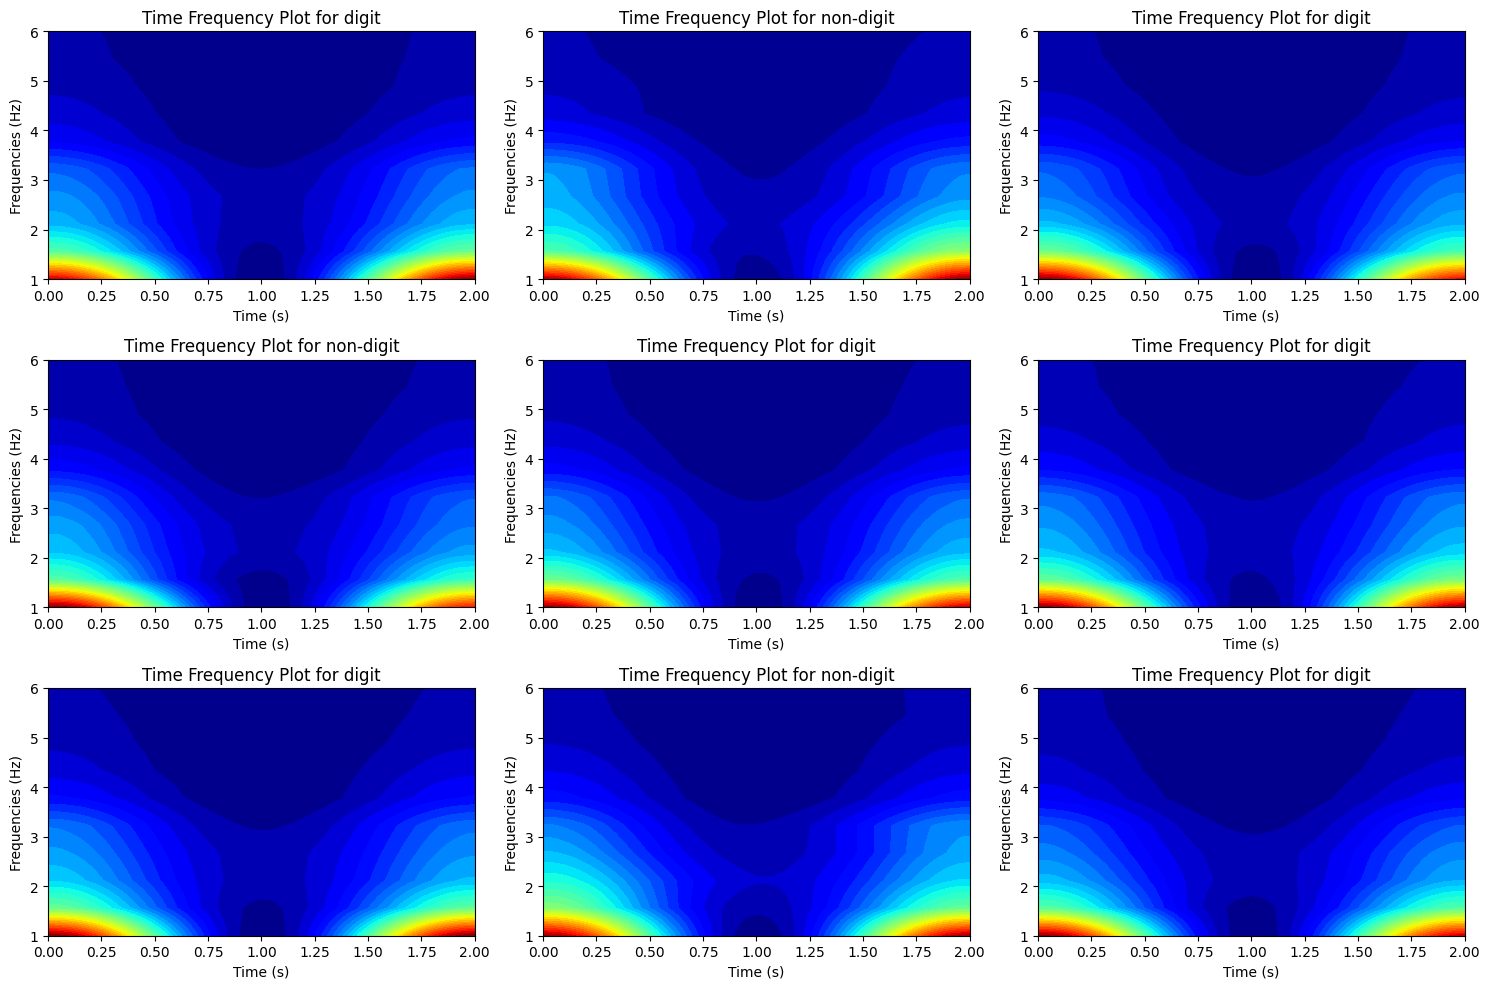

In [7]:
starting_freq = 1
end_freq = 6
num_frequencies = 10

times = np.linspace(0,2,median_length)
nData = data_array.shape[1]
cmwX, nKern, frex = get_cmwX(nData, freqrange=[starting_freq, end_freq], numfrex=num_frequencies)
tf = time_frequency(data_array, cmwX, nKern)

fig, axs = plt.subplots(3, 3, figsize=(15, 10))

for i,ax in enumerate(axs.flat):
  x = random.randint(0, tf.shape[0])
  contour = ax.contourf(times, frex, tf[x,:,:], 40, cmap='jet')
  ax.set_xlabel('Time (s)')
  ax.set_ylabel('Frequencies (Hz)')
  ax.set_title(f"Time Frequency Plot for {'non-digit' if codes[x] == -1 else 'digit'}")

fig.tight_layout()

### Saving Time-Frequency Figures as png files & Training Model

The contour plots are saved to a folder as png files.
With digits being saved under folder named '1' and non-digits being saved under folder named '0'.

I am using fastai for all AI related work. The ImageDataLoaders model from fastai automatically labels the data using the foler names. Thus 0 being the label for a non-digit and 1 being the label for a digit.

The training and initialization of the model is fairly simple thanks to fastai and after 10 training cycles the final accuracy was 84% here which according to me is pretty good.

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 61.9MB/s]


epoch,train_loss,valid_loss,accuracy,time
0,0.834151,1.501843,0.446667,00:11


epoch,train_loss,valid_loss,accuracy,time
0,0.642027,1.885651,0.446667,00:04
1,0.465486,0.920648,0.566667,00:04
2,0.371352,0.595281,0.800000,00:03
3,0.332028,1.088160,0.753333,00:03
4,0.302646,0.745221,0.786667,00:04
5,0.262791,0.770823,0.820000,00:03
6,0.230623,0.848747,0.700000,00:03
7,0.194478,0.903027,0.826667,00:04
8,0.163008,0.845715,0.826667,00:03
9,0.136817,0.782580,0.840000,00:03


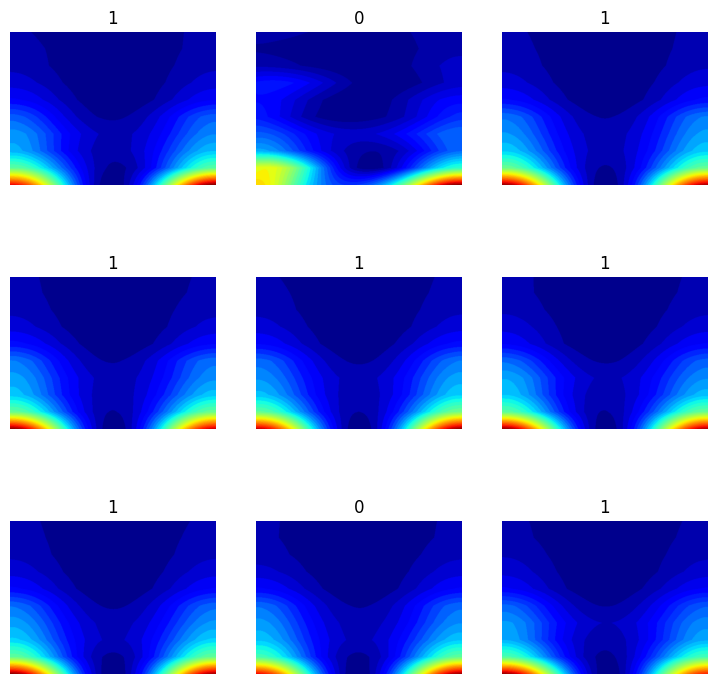

In [7]:
path = "drive/MyDrive/EEG-Data/images/"

shutil.rmtree(path) # delete previous data
for i in range(tf.shape[0]):
    code = 0 if codes[i] == -1 else 1
    folder_path = f"{path}training/{code}"
    os.makedirs(folder_path, exist_ok=True)

    fig, ax = plt.subplots()
    ax.contourf(times, frex, tf[i,:,:], 40, cmap='jet')
    ax.axis('off')

    # Save the figure as a PNG file with a tight bounding box
    file_path = f"{folder_path}/{i}.png"
    fig.savefig(file_path, bbox_inches='tight', pad_inches=0)

    # Clear the current figure to free memory
    fig.clf()
    plt.close()

dls = ImageDataLoaders.from_folder(path, train='training', valid_pct=0.2, item_tmfs=Resize(224))
dls.show_batch()
learn = vision_learner(dls, resnet34, metrics=accuracy)
learn.fine_tune(10)

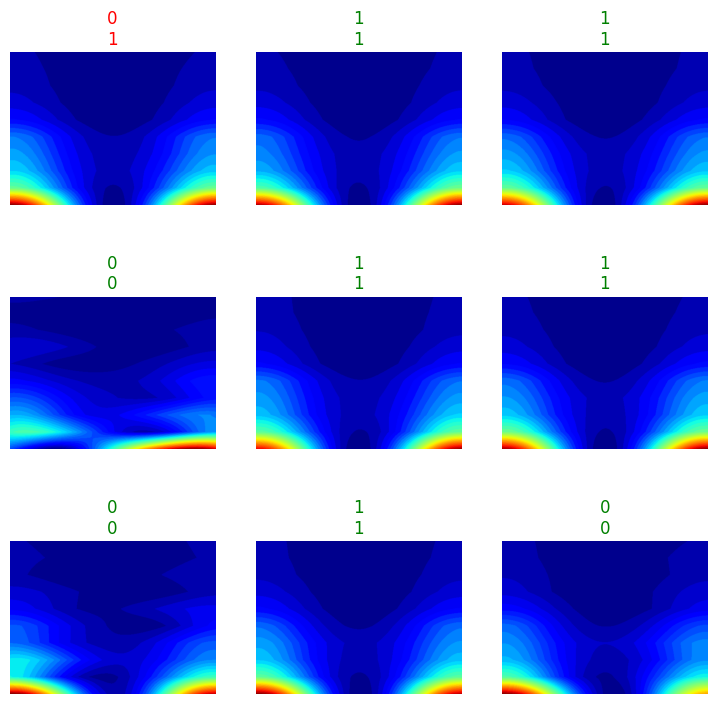

In [9]:
learn.show_results()